In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from skimage.feature import hog
from skimage import exposure
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle

In [ ]:
def extract_hog_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))  # Resize to a fixed size
    features, _ = hog(image, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys',
                      visualize=True, transform_sqrt=True)
    return features

def get_hog_feature(gray_image):
    hogfv, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(16, 16),
                           cells_per_block=(2, 2), visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 5))
    return hog_image_rescaled

def load_and_preprocess_image(img_path):
    image = cv2.imread(img_path)
    image = cv2.resize(image, target_size)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_array = get_hog_feature(gray_image)
    return img_array

In [ ]:
# Path to dataset
main_path = '/content/drive/My Drive/projects_data/fyp/Categorized_images'
dir_list = os.listdir(main_path)
print(dir_list)

['Bad', 'Neutral', 'Good', 'Very Bad', 'Very Good']


In [ ]:
labels = {'Very Bad': 4, 'Bad': 3, 'Neutral': 2, 'Good': 1, 'Very Good': 0}
image_list = {'Very Bad': [], 'Bad': [], 'Neutral': [], 'Good': [], 'Very Good': []}

In [ ]:
for dir_name in dir_list:
    files_in_dir = os.listdir(f"{main_path}/{dir_name}")
    image_list[dir_name].extend(files_in_dir)

for list_ in image_list:
    print(list_, len(image_list[list_]))

Very Bad 600
Bad 600
Neutral 600
Good 600
Very Good 600


In [ ]:
target_size = (200, 200)
y = []
X_images = []
filenames = []

In [ ]:
for key in image_list:
    print(key)
    print(image_list[key])
    for img in image_list[key]:
        img_path = f"{main_path}/{key}/{img}"
        try:
            img_array = load_and_preprocess_image(img_path)
            X_images.append(img_array)
            y.append(labels[key])
            filenames.append(img_path)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

Very Bad
['265.jpg', '264.jpg', '266.jpg', '268.jpg', '267.jpg', '269.jpg', '254.jpg', '272.jpg', '270.jpg', '255.jpg', '274.jpg', '273.jpg', '279.jpg', '275.jpg', '276.jpg', '278.jpg', '277.jpg', '287.jpg', '286.jpg', '256.jpg', '284.jpg', '280.jpg', '285.jpg', '257.jpg', '283.jpg', '282.jpg', '281.jpg', '290.jpg', '289.jpg', '288.jpg', '292.jpg', '296.jpg', '293.jpg', '294.jpg', '252.jpg', '291.jpg', '295.jpg', '297.jpg', '300.jpg', '298.jpg', '299.jpg', '301.jpg', '253.jpg', '302.jpg', '258.jpg', '303.jpg', '259.jpg', '261.jpg', '304.jpg', '305.jpg', '260.jpg', '262.jpg', '263.jpg', '251.jpg', '314.jpg', '315.jpg', '136.jpg', '319.jpg', '317.jpg', '318.jpg', '306.jpg', '321.jpg', '322.jpg', '320.jpg', '316.jpg', '326.jpg', '324.jpg', '329.jpg', '323.jpg', '328.jpg', '325.jpg', '327.jpg', '343.jpg', '400.jpg', '338.jpg', '332.jpg', '336.jpg', '334.jpg', '335.jpg', '340.jpg', '339.jpg', '333.jpg', '337.jpg', '342.jpg', '341.jpg', '331.jpg', '330.jpg', '308.jpg', '345.jpg', '344.jpg', 

In [ ]:
X_images = np.array(X_images)
y = np.array(y)
filenames = np.array(filenames)

In [ ]:
n_samples, height, width = X_images.shape
X_reshaped = X_images.reshape(n_samples, height * width)

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test, filenames_train, filenames_test = train_test_split(
    X_reshaped, y, filenames, test_size=0.2, random_state=42)


In [ ]:
# Save train and test sets
train_path = '/content/drive/My Drive/projects_data/fyp/train_set'
test_path = '/content/drive/My Drive/projects_data/fyp/test_set'
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

np.save(os.path.join(train_path, 'X_train.npy'), X_train)
np.save(os.path.join(train_path, 'y_train.npy'), y_train)
np.save(os.path.join(test_path, 'X_test.npy'), X_test)
np.save(os.path.join(test_path, 'y_test.npy'), y_test)
np.save(os.path.join(test_path, 'filenames_test.npy'), filenames_test)

In [ ]:
# Train Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.41


In [ ]:
# Save the model
with open('/content/drive/My Drive/projects_data/fyp/rf_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[51 18 13 13 18]
 [19 51 18  9 14]
 [19 10 60 20 13]
 [10 21 29 42 11]
 [32 32 26  7 44]]


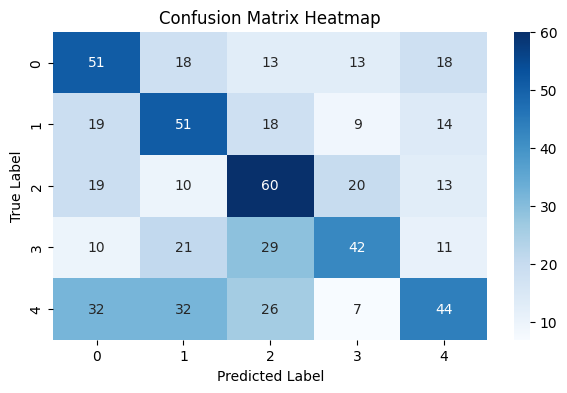

In [ ]:
plt.figure(figsize=(7, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()